# Backtest Framework

* Basics
    * Each df should be in shape $n$ rows by $u$ column
    * Where $n$ is the number of days of trading
    * $u$ is any perp that was ever in the universe.
    * Should be sparse, lots of zeros.
* Suggestions
    * Look at RJ's backtest code translated into Python and figure it out.

---

* Raw ingredients
    * Weights df
    * Close prices df
    * Funding df
    * Fees
* Processed ingredients
    * Target positions df
    * Actual positions df
    * Increment df
* Results
    * Equity df (portfolio value) 

# Data Prep

In [29]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
np.set_printoptions(suppress=True)
sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)


capital = 1e5
# model_df = pd.read_pickle('model_df.pkl').loc['2020-03-06':]
model_df = pd.read_pickle('exp_return_df.pkl')

model_df['date'] = pd.to_datetime(model_df['date'])



weights = model_df.pivot(index='date', columns='ticker', values='scaled_weight').fillna(0).reset_index()
close = model_df.pivot(index='date', columns='ticker', values='close').fillna(0).reset_index()
funding = model_df.pivot(index='date', columns='ticker', values='funding_rate').fillna(0).reset_index()


In [30]:
weights

ticker,date,1000BONKUSDT,1000LUNCUSDT,1000PEPEUSDT,1000SHIBUSDT,1INCHUSDT,AAVEUSDT,ADAUSDT,AGIXUSDT,ALGOUSDT,...,WAVESUSDT,WLDUSDT,XLMUSDT,XMRUSDT,XRPUSDT,XTZUSDT,YFIUSDT,ZECUSDT,ZILUSDT,ZRXUSDT
0,2020-03-12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,-0.137176,0.0,-0.197307,0.0,0.0,0.0,0.0,0.0
1,2020-03-13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,-0.108042,0.0,-0.217631,0.0,0.0,0.0,0.0,0.0
2,2020-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,-0.070846,0.0,-0.191546,0.0,0.0,0.0,0.0,0.0
3,2020-03-15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,-0.146946,0.0,-0.165321,0.0,0.0,0.0,0.0,0.0
4,2020-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,-0.131762,0.0,-0.161730,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,2024-02-08,0.0,0.0,0.0,0.0,0.0,0.0,-0.038101,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.061356,0.0,0.0,0.0,0.0,0.0
1426,2024-02-09,0.0,0.0,0.0,0.0,0.0,0.0,-0.028232,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.068555,0.0,0.0,0.0,0.0,0.0
1427,2024-02-10,0.0,0.0,0.0,0.0,0.0,0.0,-0.014669,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.027872,0.0,0.0,0.0,0.0,0.0
1428,2024-02-11,0.0,0.0,0.0,0.0,0.0,0.0,-0.031486,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.046038,0.0,0.0,0.0,0.0,0.0


# Simulation

In [31]:
import pandas as pd
import numpy as np

def positions_from_no_trade_buffer(current_positions, current_prices, target_weights, cap_equity, trade_buffer):

    num_assets = len(current_positions)
    target_positions = np.zeros(num_assets)
    current_weights = current_positions * current_prices / cap_equity
    
    for j in range(num_assets):
        if np.isnan(target_weights[j]) or target_weights[j] == 0:
            target_positions[j] = 0
        elif current_weights[j] < target_weights[j] - trade_buffer:
            target_positions[j] = (target_weights[j] - trade_buffer) * cap_equity / current_prices[j]
        elif current_weights[j] > target_weights[j] + trade_buffer:
            target_positions[j] = (target_weights[j] + trade_buffer) * cap_equity / current_prices[j]
        else:
            target_positions[j] = current_positions[j]
    return target_positions



def fixed_commission_backtest_with_funding(prices, target_weights, funding_rates, trade_buffer=0.0, initial_cash=10000, commission_pct=0, reinvest=True):

    # Get tickers for later
    tickers = prices.columns[1:]

    # Initial state
    num_assets = prices.shape[1] - 1  # -1 for date column
    current_positions = np.zeros(num_assets)
    previous_target_weights = np.zeros(num_assets)
    previous_prices = np.full(num_assets, 0)
    rows_list = []
    cash = initial_cash
    total_eq = np.array(0)

    # Backtest loop
    for i in range(len(prices)):
        # fetch data
        current_date = prices.iloc[i, 0]
        current_prices = prices.iloc[i, 1:]
        current_target_weights = target_weights.iloc[i, 1:]
        current_funding_rates = funding_rates.iloc[i, 1:]

        # Accrue funding on current positions
        funding = current_positions * current_prices.values * current_funding_rates.values
        funding = np.where(funding == np.nan, 0, funding)
        # PnL for the period: price change + funding
        period_pnl = current_positions * (current_prices.values - previous_prices)
        period_pnl = np.where(period_pnl == np.nan, 0, period_pnl) + funding
        # Update cash balance - includes adding back yesterday's margin and deducting today's margin
        cash += np.sum(period_pnl)
        # Update equity
        cap_equity = min(initial_cash, cash) if not reinvest else cash
        # Update positions based on no-trade buffer
        target_positions = positions_from_no_trade_buffer(current_positions, current_prices, current_target_weights, cap_equity, trade_buffer)
        # Calculate position deltas, trade values, and commissions
        trades = target_positions - current_positions

        trade_value = trades * current_prices.dropna().values
        commissions = np.abs(trade_value) * commission_pct
        # After each iteration, set positions to current positions
        current_positions = target_positions
        position_value = current_positions * current_prices.dropna().values

        # Update cash with impact from commissions
        cash -= np.sum(commissions)
        total_eq = np.append(total_eq, cash)

        row_dict = {
            "Date": [current_date] * (num_assets),
            "Close": current_prices.dropna().values,
            "Position": current_positions,
            "Value": position_value,
            "Funding": funding,
            "PeriodPnL": period_pnl,
            "Trades": trades,  
            "TradeValue": trade_value,
            "Commission": commissions,
        }
        rows_list.append(row_dict)
        previous_prices = current_prices
    
    # Combine list of dictionaries into a DataFrame
    result_df = pd.DataFrame(rows_list)
    result_df = result_df.set_index(result_df.Date.apply(lambda x:x[0])).drop(['Date'],axis=1)
    total_eq = pd.Series(total_eq[1:],index=result_df.index)    
    sharpe = total_eq.pct_change().mean()/total_eq.pct_change().std()*16
    return result_df, total_eq, sharpe


def split_column_lists(df, tickers):
    result_dfs = {}
    for col in df.columns:
        # Apply function to split lists into separate columns
        result_df = df[col].apply(pd.Series)
        # Rename columns with tickers
        result_df.columns = tickers
        # Store the resulting DataFrame
        result_dfs[col] = result_df
    return result_dfs


# Analysis 

In [32]:
result_df, total_eq, sharpe = fixed_commission_backtest_with_funding(close, weights,funding, trade_buffer=0.05,initial_cash=10000, commission_pct=0.0015, reinvest=False)
resulting_dfs = split_column_lists(result_df, weights.columns[1:].tolist())
close_df = resulting_dfs['Close']
position_df = resulting_dfs['Position']
value_df = resulting_dfs['Value']
funding_df = resulting_dfs['Funding']
periodpnl_df = resulting_dfs['PeriodPnL']
trades_df = resulting_dfs['Trades']
tradevalue_df = resulting_dfs['TradeValue']
commission_df = resulting_dfs['Commission']


In [33]:
# buff_sharpes = np.array([])
# for buffer in [0.00, 0.01,0.02, 0.03,0.04,0.05,0.06,0.07]:
#     _,_, buff_sharpe = fixed_commission_backtest_with_funding(close, weights,funding, trade_buffer=buffer,initial_cash=10000, commission_pct=0.0015,reinvest=False)
#     buff_sharpes = np.append(buff_sharpes, buff_sharpe)

# pd.Series(buff_sharpes,index=[0,0.01,0.02, 0.03,0.04,0.05,0.06,0.07]).plot(marker='o', figsize=(10,4), title='Sharpe across trading buffer values')

In [34]:
def plot_equity(total_eq, sharpe):
    total_rets = (total_eq.iloc[-1] - total_eq.iloc[1])/total_eq.iloc[1] * 100
    annual_rets = total_eq.pct_change().mean() * 255 * 100
    annual_vol = total_eq.pct_change().std() * 16 * 100

    fig, ax = plt.subplots(figsize=(16,5))
    ax = total_eq.plot(fontsize=13)
    plt.title(f"Crypto Stat Arb Simulation - Total return {round(total_rets,1)}%, annualized return {round(annual_rets,1)}%, vol {round(annual_vol,1)}% \n Weighted 30-day rolling regression Carry/Momo/Breakout, costs 0.15% of trade value , trade buffer 0.05, trade on close, Sharpe {round(sharpe, 2)}", fontsize=16)

    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.legend()
    plt.show()    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


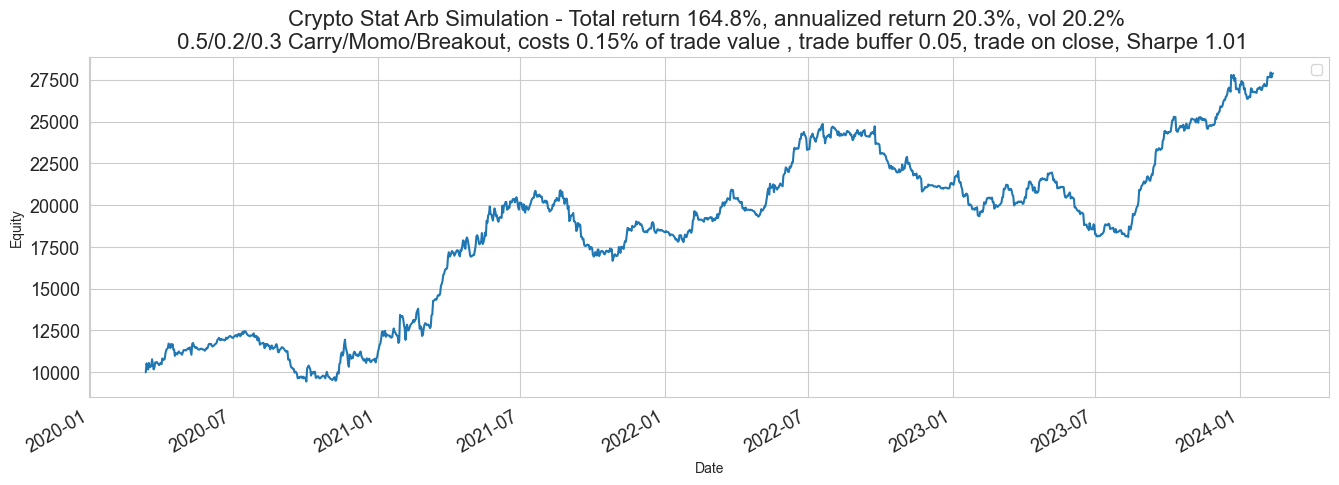

In [35]:
plot_equity(total_eq,sharpe)

In [36]:
np.log(40000) - np.log(10000)

1.386294361119889

<AxesSubplot: title={'center': 'Return distribution, skew: 1.29'}, ylabel='Frequency'>

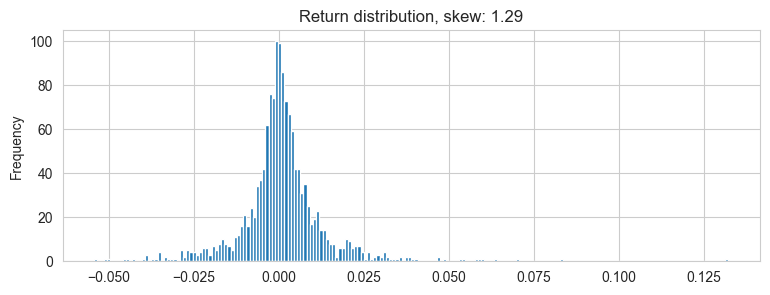

In [37]:
total_eq.iloc[:].pct_change().plot(kind='hist',bins=200,figsize=(9,3),title=f'Return distribution, skew: {total_eq.iloc[:].pct_change().skew().round(2)}')

<AxesSubplot: title={'center': 'Turnover as % of initial cash (10k), trade buffer 0.05'}, xlabel='Date'>

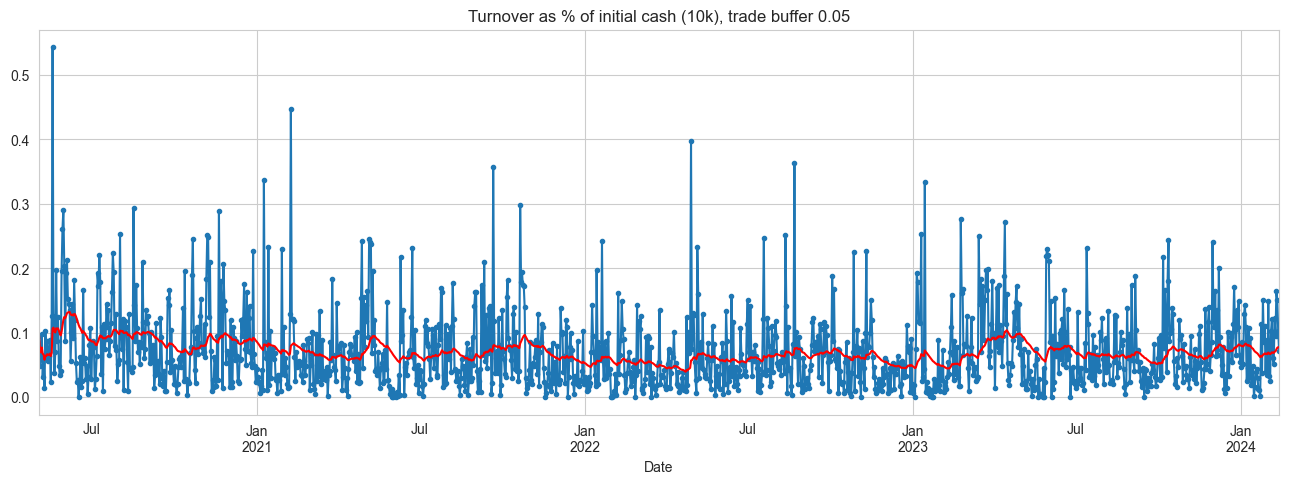

In [38]:
tradevalue_df.iloc[50:].abs().sum(axis=1).div(10000).plot(figsize=(16,5), title='Turnover as % of initial cash (10k), trade buffer 0.05', marker='o',markersize=3)
tradevalue_df.iloc[50:].abs().sum(axis=1).div(10000).ewm(30).mean().plot(figsize=(16,5), color='red')

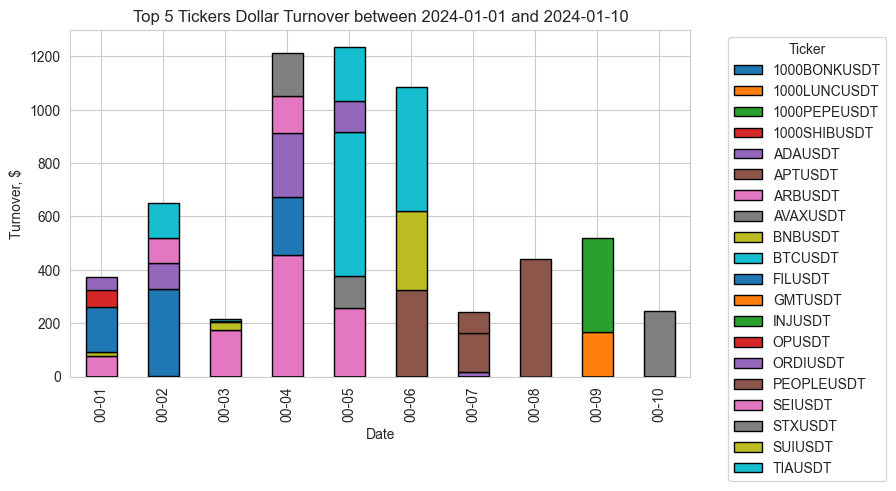

In [39]:

from matplotlib.dates import DateFormatter

# Specify the date range
start_date = "2024-01-01"
end_date = "2024-01-10"


# Filter the DataFrame for the specified date range
filtered_df = tradevalue_df.loc[start_date:end_date]

# Get the top N tickers for each day based on total turnover
top_n = 5  # Change this to the desired number of top tickers
filtered_df = filtered_df.apply(lambda x: x.nlargest(top_n), axis=1)

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(8, 4.5))
filtered_df.plot(kind='bar', stacked=True, edgecolor='black',ax=ax)
date_format = DateFormatter("%M-%d")
ax.xaxis.set_major_formatter(date_format)

plt.title(f"Top {top_n} Tickers Dollar Turnover between {start_date} and {end_date}")
plt.xlabel('Date')
plt.ylabel('Turnover, $')
plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Start date,2020-03-12
End date,2024-02-12
Total months,68
,Backtest
Annual return,19.8%
Cumulative returns,179.0%
Annual volatility,20.0%
Sharpe ratio,1.00
Calmar ratio,0.73
Stability,0.73
Max drawdown,-27.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.22,2022-07-20,2023-08-12,2023-10-07,318
1,24.24,2020-07-16,2020-10-02,2021-01-10,127
2,20.21,2021-08-21,2021-10-26,2022-03-26,155
3,11.83,2021-02-21,2021-02-26,2021-03-12,15
4,11.13,2021-01-29,2021-02-05,2021-02-19,16


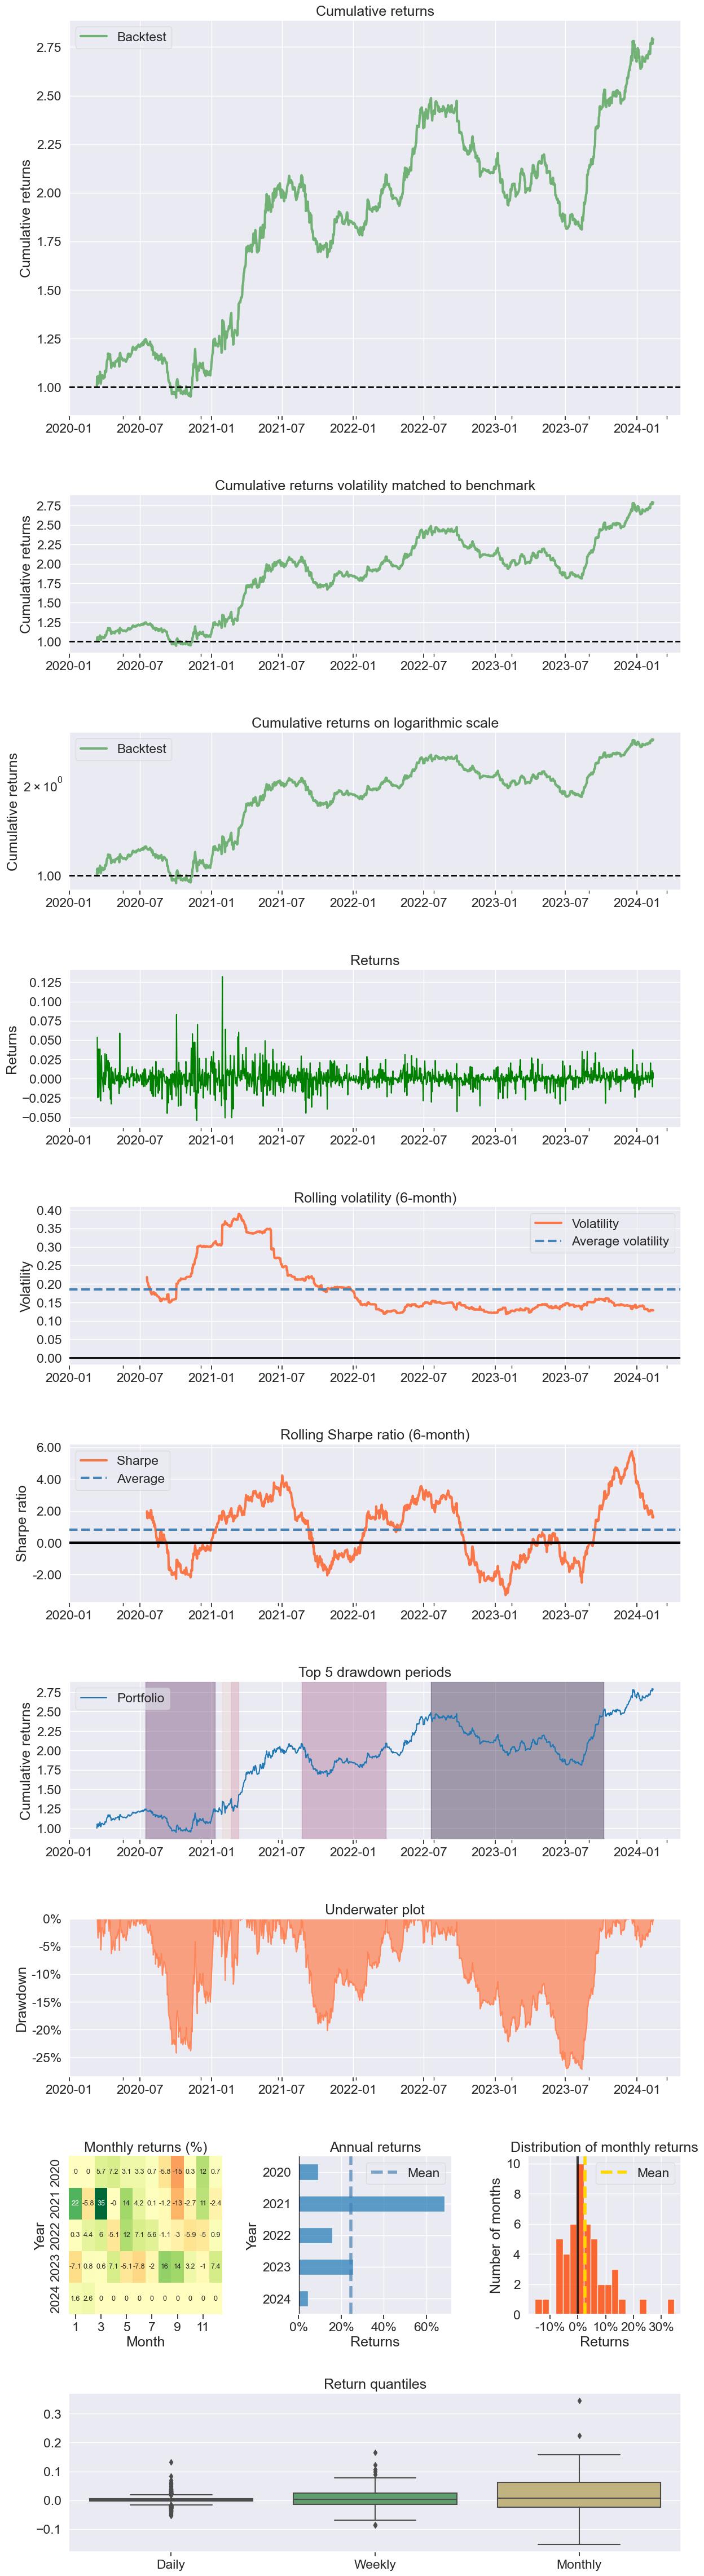

In [40]:
import pyfolio as pf
fig = pf.create_returns_tear_sheet(total_eq.pct_change(), return_fig=True)

for ax in fig.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on